In [1]:
data_path = './hw2_data/'

In [2]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import io
import sys
import os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
random.seed(134)


In [3]:
MAX_VOCAB_SIZE = 150000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

MAX_SENTENCE_LENGTH = 50
BATCH_SIZE = 128
EMBED_SIZE = 300

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Dataset Preparation

In [29]:
# y_label_map = {'neutral':0,
#                 'contradiction': 1, 
#                 'entailment': 2};

y_label_map = {'contradiction':0,'neutral':1,'entailment':2}
num_to_label = ['contradiction','neutral','entailment']

def get_string_tokenized_data(data_mat_path):
    df = pd.read_csv(os.path.join(data_mat_path), sep="\t")
    data = np.array(df);
    data = data.astype(str)
    
    tokenized_data_x = len(data) * [None];
    y_labels = [y_label_map[x] for x in data[:, 2] ];
    
    all_tokens = [];
    
    for i,x in enumerate(data):
        tokenized_data_x[i] = [x[0].split(), x[1].split()];
        all_tokens += (tokenized_data_x[i][0] + tokenized_data_x[i][1])

    return all_tokens, tokenized_data_x, y_labels
        


# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens1, tokens2 in tokens_data:
        index_list1 = [token2id[token] if token in token2id else UNK_IDX for token in tokens1]
        index_list2 = [token2id[token] if token in token2id else UNK_IDX for token in tokens2]
        indices_data.append([index_list1, index_list2])
    return indices_data


def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(MAX_VOCAB_SIZE))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    embedding_dict = np.random.randn(MAX_VOCAB_SIZE+2, EMBED_SIZE)
    all_train_tokens = []
    i = 0
    
    for line in fin:
        tokens = line.rstrip().split(' ')
        all_train_tokens.append(tokens[0])
        embedding_dict[i+2] = list(map(float, tokens[1:]))
        i += 1
        if i == MAX_VOCAB_SIZE:
            break
            
    return embedding_dict, all_train_tokens


In [6]:
_, val_data_x, val_data_y = get_string_tokenized_data(os.path.join(data_path, 'snli_val.tsv'))
_, train_data_x, train_data_y = get_string_tokenized_data(os.path.join(data_path, 'snli_train.tsv'))

fasttext_embedding_dict, all_fasttext_tokens = load_vectors('wiki-news-300d-1M.vec')

token2id, id2token = build_vocab(all_fasttext_tokens)
train_data_indices = token2index_dataset(train_data_x, token2id)
val_data_indices = token2index_dataset(val_data_x, token2id)


# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))

Train dataset size is 100000
Val dataset size is 1000


In [7]:
count = 0;
for x in train_data_indices:
    if 1 in set(x[0]):
        count+=1

In [8]:
count/len(train_data_indices)

0.0712

### Dataset Pytorch Classes

In [9]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_x, target_list):
        """
        @param data_list: list of newsgroup tokens
        @param target_list: list of newsgroup targets

        """
        self.data_x = data_x;
        self.target_list = target_list
        
        assert(len(data_x) == len(target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        prem_token_idx = self.data_x[key][0][:MAX_SENTENCE_LENGTH]
        hyp_token_idx = self.data_x[key][1][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [prem_token_idx, hyp_token_idx, label]


def encode_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    prem_data_list = []
    hyp_data_list = []
    label_list = []
    length_list = []
    # print("collate batch: ", batch[0][0])
    # batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
    # padding
    for datum in batch:
        prem_padded_vec = np.pad(np.array(datum[0]),
                                 pad_width=((0, MAX_SENTENCE_LENGTH - len(datum[0]))),
                                 mode="constant", constant_values=0)
        hyp_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0, MAX_SENTENCE_LENGTH - len(datum[1]))),
                                mode="constant", constant_values=0)
        prem_data_list.append(prem_padded_vec)
        hyp_data_list.append(hyp_padded_vec)
    return [torch.from_numpy((np.array(prem_data_list))), torch.from_numpy(np.array(hyp_data_list)),
            torch.LongTensor(label_list)]

In [10]:
train_dataset = SNLIDataset(train_data_indices, train_data_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=encode_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(val_data_indices, val_data_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=encode_collate_func,
                                           shuffle=True)

In [58]:
best_rnn = torch.load('./cnn_1/best_cnn.pth')

/home/sm7582/.conda/envs/denoising/lib/python3.6/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [59]:
i=0;
for prem_data, hyp_data, labels in val_loader:
    i += 1;
    if i>1:
        break;
    prem_data_batch, hyp_data_batch, label_batch = prem_data.to(device), hyp_data.to(device),labels.to(device)
    outputs = F.softmax(best_rnn(prem_data_batch, hyp_data_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]

    print(predicted.eq(label_batch.view_as(predicted)) )

tensor([[1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],

In [60]:
eq = predicted.eq(label_batch.view_as(predicted));

In [61]:
eq = eq.cpu().data.numpy().flatten();

In [62]:
prem_data_batch, hyp_data_batch, label_batch = prem_data_batch.data.cpu().numpy(), hyp_data_batch.data.cpu().numpy(), label_batch.data.cpu().numpy()

In [63]:
outputs[i]

tensor([0.7759, 0.1777, 0.0465], device='cuda:0', grad_fn=<SelectBackward>)

In [64]:
outputs = outputs.data.cpu().numpy()

In [65]:
def get_string(num_list):
    sent = '';
    for x in num_list:
        if x == 0:
            break;
        sent += id2token[x] + ' ';
    return sent

In [66]:
print('Correct Predictions\n')
count_correct = 0;

for i, is_correct in enumerate(eq):
    
    if count_correct > 2:
        break;
        
    if is_correct == 1:
        count_correct += 1;
        print('Prem: ',  get_string(prem_data_batch[i] ) )
        print('Hyp: ', get_string(hyp_data_batch[i] ) )
        print('Predicted Label: ', num_to_label[np.argmax(outputs[i])] )
        print('Correct Label: ', num_to_label[label_batch[i]])
        print(''.join(['-']*10))
        
print('Incorrect Predictions\n')
count_correct = 0;

for i, is_correct in enumerate(eq):
    
    if count_correct > 2:
        break;
        
    if is_correct == 0:
        count_correct += 1;
        print('Prem: ',  get_string(prem_data_batch[i] ) )
        print('Hyp: ', get_string(hyp_data_batch[i] ) )
        print('Predicted Label: ', num_to_label[np.argmax(outputs[i])] )
        print('Correct Label: ', num_to_label[label_batch[i]])
        print(''.join(['-']*10))

Correct Predictions

Prem:  A young girl is swimming in a pool . 
Hyp:  The girl is practicing for a swim meet . 
Predicted Label:  neutral
Correct Label:  neutral
----------
Prem:  A woman prepares to strike a volleyball . 
Hyp:  The woman is shooting a basket through the hoop . 
Predicted Label:  contradiction
Correct Label:  contradiction
----------
Prem:  A person floating on a river near a metropolitan area . 
Hyp:  A man floating on a river near a metropolitan area . 
Predicted Label:  neutral
Correct Label:  neutral
----------
Incorrect Predictions

Prem:  A man and a woman repairing something . 
Hyp:  A male and female work together to repair something . 
Predicted Label:  neutral
Correct Label:  entailment
----------
Prem:  Three Oklahoma Sooners playing football against another team , one of the <unk> with the ball in their possession . 
Hyp:  Rival college football players are playing a football game . 
Predicted Label:  contradiction
Correct Label:  neutral
----------
Prem:

## Neural Networks

#### Generic Functions to be used

In [11]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for prem_data, hyp_data, labels in loader:
        prem_data_batch, hyp_data_batch, label_batch = prem_data.to(device), hyp_data.to(device),labels.to(device)
        outputs = F.softmax(model(prem_data_batch, hyp_data_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)


def plot_acc(train_accs, val_accs, filename):
    f = plt.figure()
    plt.plot(train_accs, label='train');
    plt.plot(val_accs, label='val');
    plt.title(filename);
    plt.legend()

    f.savefig(os.path.join(filename[:3], filename + ".pdf"), bbox_inches='tight')
    plt.show()

In [12]:
def train_and_evaluate(model_type = 'cnn', kernel_size = 3, hidden_size = 3, linear_hid_dim = 10, 
                       combine_method = 'concat', regularization = 'none'):

    file_name = '_'.join([model_type, 'kernel_size='+str(kernel_size), 'hidden_size='+str(hidden_size), 'linear_hid_dim='+str(linear_hid_dim), 
                       'combine_method='+str(combine_method), 'regularization='+str(regularization)]);
    print('\n'.join([model_type, 'kernel_size='+str(kernel_size), 'hidden_size='+str(hidden_size), 'linear_hid_dim='+str(linear_hid_dim), 
                       'combine_method='+str(combine_method), 'regularization='+str(regularization)]))
    sys.stdout.flush()
    
    learning_rate = 1e-3;
    num_epochs = 10;
    
    dropout = (regularization == 'dropout')
    

    if(model_type == 'cnn'):
        model = CNN(EMBED_SIZE , hidden_size, MAX_VOCAB_SIZE+2, kernel_size, linear_hid_dim, combine_method, dropout);
    elif(model_type == 'rnn'):
        model = RNN(EMBED_SIZE , hidden_size, MAX_VOCAB_SIZE+2,  linear_hid_dim, combine_method, dropout);
    else:
        error('invalid model type')
        
    model = model.to(device);

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()

    if regularization == 'weight_decay':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val = 0;
    best_state_dict = None;
    
    train_acc_array = [];
    val_acc_array = [];
    
    for epoch in range(num_epochs):

        for i, (prem, hyp, label) in enumerate(train_loader):
            
#             if i>300:
#                 break;
            model.train()
            
            prem_batch, hyp_batch, label_batch = prem.to(device), hyp.to(device), label.to(device);
            
            optimizer.zero_grad()
            
            outputs = model(prem_batch, hyp_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if (i+1) % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                
                if val_acc > best_val:
                    best_state_dict = model.state_dict();
                    best_val = val_acc;
                    
                val_acc_array.append(val_acc);
                train_acc = test_model(train_loader, model);
                train_acc_array.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
                sys.stdout.flush()
                
    plot_acc(train_acc_array, val_acc_array, file_name)
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    sys.stdout.flush()
    
    model.load_state_dict(best_state_dict)
    
    return test_model(train_loader, model), test_model(val_loader, model), model

## CNN Model

In [57]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size, kernel_size, linear_hidden_dim, combine_method, dropout):

        super(CNN, self).__init__()
        
        assert(kernel_size % 2 == 1);
        assert(combine_method in ['concat', 'mul', 'add']);
        
        padding = int( (kernel_size-1)/2 );        

        self.hidden_size = hidden_size;
        self.combine_method = combine_method;
        self.dropout = dropout;
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(np.array(fasttext_embedding_dict)).cuda(), freeze = False)
#         self.embedding.weight.data.copy_(torch.from_numpy(np.array(fasttext_embedding_dict).copy()))
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=padding)


        
        if combine_method == 'concat':
            self.linear_layers1 = nn.Linear(hidden_size*2, linear_hidden_dim)
        else:
            self.linear_layers1 = nn.Linear(hidden_size, linear_hidden_dim)
            
        self.linear_layers2 =  nn.Linear(linear_hidden_dim, 3)
        
#         self.xavier_init(self.linear_layers1);
#         self.xavier_init(self.linear_layers2);
        
        if self.dropout:
            self.dropout_layer = nn.Dropout(0.5);
            
        
    def xavier_init(self, layer):
        torch.nn.init.xavier_normal_(layer.weight.data)
        layer.bias.data.fill_(0.01)
    
    def indivual_encoding(self, x):
        batch_size, seq_len = x.size()

        embed = self.embedding(x)
        m = (x == 1)
        m = m.unsqueeze(2).repeat(1, 1, EMBED_SIZE).type(torch.FloatTensor).to(device);
       
        embed = m * embed + (1-m) * embed.clone().detach()
        
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
        
#         print(hidden.shape)
        hidden = torch.max(hidden, 1)[0]
#         print(hidden.shape)
        
        return hidden
    
    def forward(self, prem, hyp):
        prem_vector = self.indivual_encoding(prem);
        hyp_vector = self.indivual_encoding(hyp);
        
        if self.combine_method == 'concat':
            final_code = torch.cat((prem_vector, hyp_vector), dim=1);
        elif self.combine_method == 'mul':
            final_code = prem_vector * hyp_vector;
        elif self.combine_method == 'add':
            final_code = prem_vector + hyp_vector;
            

        final_code = self.linear_layers1(final_code);
        final_code = F.relu(final_code);
        if self.dropout:
            final_code = self.dropout_layer(final_code);
        final_code = self.linear_layers2(final_code)
            
            
        return final_code

        

## RNN Model

In [12]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size, linear_hidden_dim, combine_method, dropout):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.combine_method = combine_method;
        self.dropout = dropout;
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(np.array(fasttext_embedding_dict).copy()))
        
        self.bi_gru = nn.GRU(emb_size, hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        
        if combine_method == 'concat':
            self.linear_layers1 = nn.Linear(hidden_size*2, linear_hidden_dim)
        else:
            self.linear_layers1 = nn.Linear(hidden_size, linear_hidden_dim)
            
        self.linear_layers2 =  nn.Linear(linear_hidden_dim, 3)
        
        if self.dropout:
            self.dropout_layer = nn.Dropout(0.5);
            
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.zeros(2, batch_size, self.hidden_size).to(device)
        return hidden
    
    def encode(self, x):
        
        batch_size, seq_len = x.size()
        self.hidden = self.init_hidden(batch_size)
        embed = self.embedding(x)
        m = (x == 1)
        m = m.unsqueeze(2).repeat(1, 1, EMBED_SIZE).type(torch.FloatTensor).to(device)
        embed = m * embed + (1-m) * embed.clone().detach()
        
        # embed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths.cpu().numpy(), batch_first=True)
        
        output, hidden = self.bi_gru(embed, self.hidden)
        hidden = torch.sum(hidden, dim = 0)
        
#         hidden = hidden.index_select(0, idx_unsort)
        
        return hidden
    
    
    def forward(self, prem, hyp):
        batch_size, seq_len = prem.size()

        prem_vector = self.encode(prem)
        hyp_vector = self.encode(hyp)
        
        if self.combine_method == 'concat':
            final_code = torch.cat((prem_vector, hyp_vector), dim=1);
        elif self.combine_method == 'mul':
            final_code = prem_vector * hyp_vector;
        elif self.combine_method == 'add':
            final_code = prem_vector + hyp_vector;
            

        final_code = self.linear_layers1(final_code);
        final_code = F.relu(final_code);
        if self.dropout:
            final_code = self.dropout_layer(final_code);
        final_code = self.linear_layers2(final_code)
            
            
        return final_code

### Hyperparameter Tuninig and Training

In [15]:
model_type_list = ['cnn']
hidden_size_list = [50]
kernel_size_list = [3, 5]
linear_hid_dim_list = [400]
regularization_list = ['none', 'dropout', 'weight_decay'];
# regularization_list = ['none']
combine_method_list = ['concat', 'mul', 'add']
# combine_method_list = ['concat']

In [16]:
assert(len(model_type_list) == 1)

In [17]:
best_acc = 0;

cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 57.5, Train Acc: 57.191
Epoch: [1/10], Step: [600/782], Validation Acc: 58.7, Train Acc: 60.653
Epoch: [2/10], Step: [300/782], Validation Acc: 60.1, Train Acc: 63.309
Epoch: [2/10], Step: [600/782], Validation Acc: 62.5, Train Acc: 65.216
Epoch: [3/10], Step: [300/782], Validation Acc: 62.4, Train Acc: 67.413
Epoch: [3/10], Step: [600/782], Validation Acc: 63.4, Train Acc: 68.372
Epoch: [4/10], Step: [300/782], Validation Acc: 62.7, Train Acc: 69.687
Epoch: [4/10], Step: [600/782], Validation Acc: 61.3, Train Acc: 71.097
Epoch: [5/10], Step: [300/782], Validation Acc: 63.4, Train Acc: 72.882
Epoch: [5/10], Step: [600/782], Validation Acc: 62.2, Train Acc: 72.934
Epoch: [6/10], Step: [300/782], Validation Acc: 62.1, Train Acc: 73.924
Epoch: [6/10], Step: [600/782], Validation Acc: 63.1, Train Acc: 74.879
Epoch: [7/10], Step: [300/782], Validation

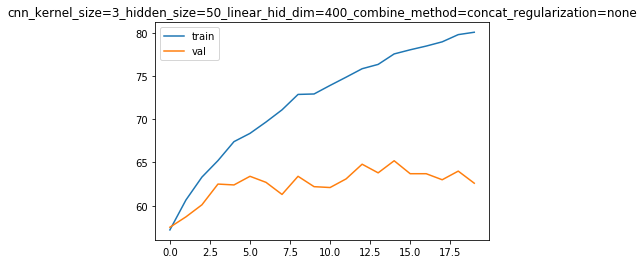

After training for 10 epochs
Train Acc 80.794
Val Acc 63.1
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 56.4, Train Acc: 56.505
Epoch: [1/10], Step: [600/782], Validation Acc: 59.2, Train Acc: 60.471
Epoch: [2/10], Step: [300/782], Validation Acc: 60.5, Train Acc: 63.679
Epoch: [2/10], Step: [600/782], Validation Acc: 59.2, Train Acc: 65.263
Epoch: [3/10], Step: [300/782], Validation Acc: 60.4, Train Acc: 67.323
Epoch: [3/10], Step: [600/782], Validation Acc: 60.8, Train Acc: 68.283
Epoch: [4/10], Step: [300/782], Validation Acc: 59.8, Train Acc: 70.213
Epoch: [4/10], Step: [600/782], Validation Acc: 60.2, Train Acc: 71.174
Epoch: [5/10], Step: [300/782], Validation Acc: 58.6, Train Acc: 72.357
Epoch: [5/10], Step: [600/782], Validation Acc: 59.9, Train Acc: 73.756
Epoch: [6/10], Step: [300/782], Validation Acc: 60.1, Train Acc: 75.067
Epoch: [6/10], Step: [600/782], Validation Acc: 59.9, T

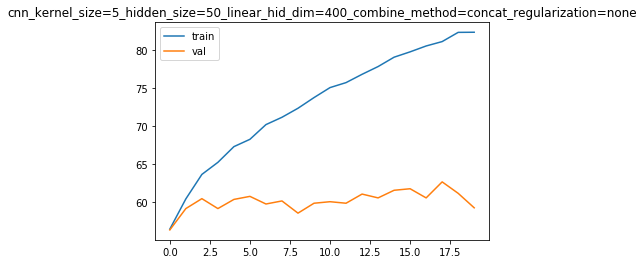

After training for 10 epochs
Train Acc 82.58
Val Acc 61.7


/home/sm7582/.conda/envs/denoising/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 51.3, Train Acc: 52.086
Epoch: [1/10], Step: [600/782], Validation Acc: 51.8, Train Acc: 54.884
Epoch: [2/10], Step: [300/782], Validation Acc: 57.1, Train Acc: 59.445
Epoch: [2/10], Step: [600/782], Validation Acc: 56.9, Train Acc: 60.646
Epoch: [3/10], Step: [300/782], Validation Acc: 57.5, Train Acc: 62.554
Epoch: [3/10], Step: [600/782], Validation Acc: 55.2, Train Acc: 62.99
Epoch: [4/10], Step: [300/782], Validation Acc: 57.4, Train Acc: 65.203
Epoch: [4/10], Step: [600/782], Validation Acc: 57.1, Train Acc: 65.79
Epoch: [5/10], Step: [300/782], Validation Acc: 57.4, Train Acc: 66.832
Epoch: [5/10], Step: [600/782], Validation Acc: 58.3, Train Acc: 67.708
Epoch: [6/10], Step: [300/782], Validation Acc: 58.2, Train Acc: 67.858
Epoch: [6/10], Step: [600/782], Validation Acc: 57.3, Train Acc: 68.832
Epoch: [7/10], Step: [300/782], Validation Acc:

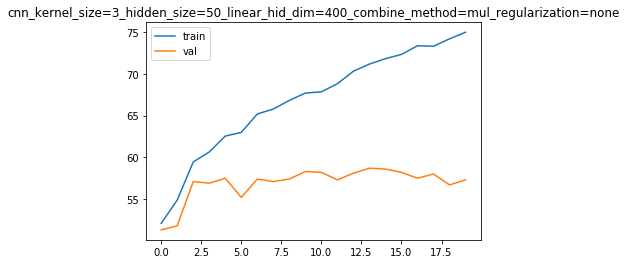

After training for 10 epochs
Train Acc 74.964
Val Acc 57.1
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 49.7, Train Acc: 52.116
Epoch: [1/10], Step: [600/782], Validation Acc: 51.7, Train Acc: 54.787
Epoch: [2/10], Step: [300/782], Validation Acc: 55.6, Train Acc: 58.781
Epoch: [2/10], Step: [600/782], Validation Acc: 57.4, Train Acc: 59.449
Epoch: [3/10], Step: [300/782], Validation Acc: 57.3, Train Acc: 63.084
Epoch: [3/10], Step: [600/782], Validation Acc: 56.7, Train Acc: 63.055
Epoch: [4/10], Step: [300/782], Validation Acc: 57.0, Train Acc: 66.378
Epoch: [4/10], Step: [600/782], Validation Acc: 55.7, Train Acc: 67.366
Epoch: [5/10], Step: [300/782], Validation Acc: 58.3, Train Acc: 68.632
Epoch: [5/10], Step: [600/782], Validation Acc: 57.9, Train Acc: 69.902
Epoch: [6/10], Step: [300/782], Validation Acc: 58.0, Train Acc: 71.072
Epoch: [6/10], Step: [600/782], Validation Acc: 58.7, Trai

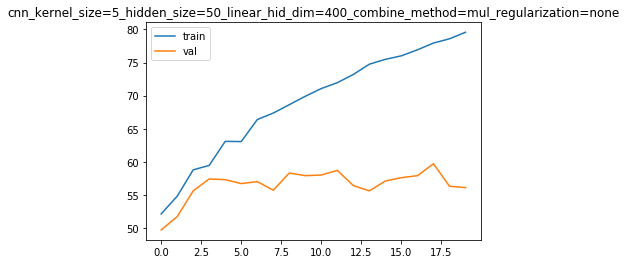

After training for 10 epochs
Train Acc 79.706
Val Acc 57.0
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=add
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 49.2, Train Acc: 50.257
Epoch: [1/10], Step: [600/782], Validation Acc: 50.5, Train Acc: 52.274
Epoch: [2/10], Step: [300/782], Validation Acc: 53.4, Train Acc: 56.717
Epoch: [2/10], Step: [600/782], Validation Acc: 53.0, Train Acc: 58.706
Epoch: [3/10], Step: [300/782], Validation Acc: 55.9, Train Acc: 60.662
Epoch: [3/10], Step: [600/782], Validation Acc: 56.7, Train Acc: 61.088
Epoch: [4/10], Step: [300/782], Validation Acc: 56.6, Train Acc: 61.948
Epoch: [4/10], Step: [600/782], Validation Acc: 55.7, Train Acc: 63.311
Epoch: [5/10], Step: [300/782], Validation Acc: 56.1, Train Acc: 64.066
Epoch: [5/10], Step: [600/782], Validation Acc: 55.7, Train Acc: 65.876
Epoch: [6/10], Step: [300/782], Validation Acc: 55.8, Train Acc: 66.709
Epoch: [6/10], Step: [600/782], Validation Acc: 53.8, Trai

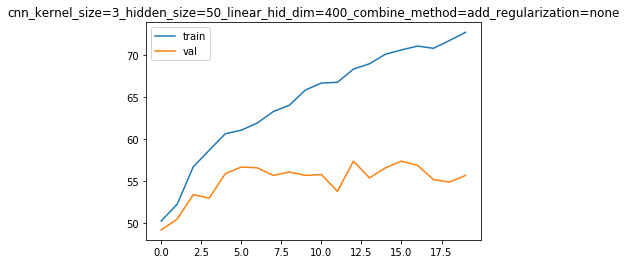

After training for 10 epochs
Train Acc 72.659
Val Acc 57.3
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=add
regularization=none
Epoch: [1/10], Step: [300/782], Validation Acc: 51.7, Train Acc: 51.571
Epoch: [1/10], Step: [600/782], Validation Acc: 53.2, Train Acc: 54.046
Epoch: [2/10], Step: [300/782], Validation Acc: 52.8, Train Acc: 56.558
Epoch: [2/10], Step: [600/782], Validation Acc: 54.5, Train Acc: 59.317
Epoch: [3/10], Step: [300/782], Validation Acc: 55.4, Train Acc: 61.221
Epoch: [3/10], Step: [600/782], Validation Acc: 55.4, Train Acc: 61.424
Epoch: [4/10], Step: [300/782], Validation Acc: 54.7, Train Acc: 63.704
Epoch: [4/10], Step: [600/782], Validation Acc: 55.3, Train Acc: 64.389
Epoch: [5/10], Step: [300/782], Validation Acc: 55.3, Train Acc: 66.05
Epoch: [5/10], Step: [600/782], Validation Acc: 56.6, Train Acc: 67.401
Epoch: [6/10], Step: [300/782], Validation Acc: 55.3, Train Acc: 68.413
Epoch: [6/10], Step: [600/782], Validation Acc: 56.1, Train

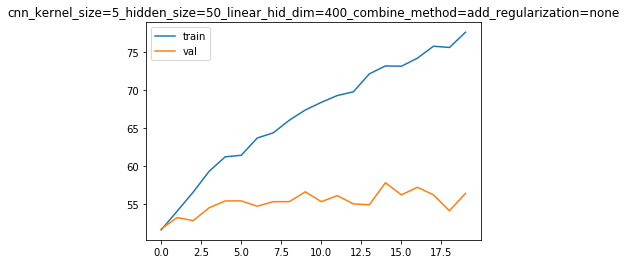

After training for 10 epochs
Train Acc 76.962
Val Acc 56.8
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 54.7, Train Acc: 56.52
Epoch: [1/10], Step: [600/782], Validation Acc: 58.7, Train Acc: 60.51
Epoch: [2/10], Step: [300/782], Validation Acc: 59.3, Train Acc: 62.979
Epoch: [2/10], Step: [600/782], Validation Acc: 60.0, Train Acc: 63.796
Epoch: [3/10], Step: [300/782], Validation Acc: 60.9, Train Acc: 66.159
Epoch: [3/10], Step: [600/782], Validation Acc: 62.2, Train Acc: 66.563
Epoch: [4/10], Step: [300/782], Validation Acc: 61.0, Train Acc: 68.361
Epoch: [4/10], Step: [600/782], Validation Acc: 60.8, Train Acc: 69.02
Epoch: [5/10], Step: [300/782], Validation Acc: 63.0, Train Acc: 70.269
Epoch: [5/10], Step: [600/782], Validation Acc: 61.7, Train Acc: 70.604
Epoch: [6/10], Step: [300/782], Validation Acc: 62.0, Train Acc: 71.9
Epoch: [6/10], Step: [600/782], Validation Acc: 62.7, Tra

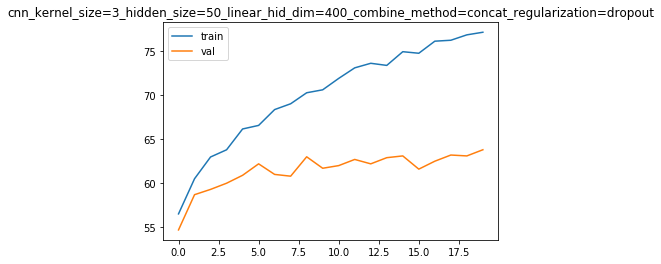

After training for 10 epochs
Train Acc 77.011
Val Acc 63.1
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 53.0, Train Acc: 55.737
Epoch: [1/10], Step: [600/782], Validation Acc: 56.2, Train Acc: 60.257
Epoch: [2/10], Step: [300/782], Validation Acc: 57.3, Train Acc: 62.998
Epoch: [2/10], Step: [600/782], Validation Acc: 60.1, Train Acc: 64.578
Epoch: [3/10], Step: [300/782], Validation Acc: 59.6, Train Acc: 66.07
Epoch: [3/10], Step: [600/782], Validation Acc: 62.1, Train Acc: 66.888
Epoch: [4/10], Step: [300/782], Validation Acc: 58.1, Train Acc: 68.827
Epoch: [4/10], Step: [600/782], Validation Acc: 60.1, Train Acc: 69.571
Epoch: [5/10], Step: [300/782], Validation Acc: 59.6, Train Acc: 70.73
Epoch: [5/10], Step: [600/782], Validation Acc: 60.5, Train Acc: 71.925
Epoch: [6/10], Step: [300/782], Validation Acc: 59.9, Train Acc: 72.571
Epoch: [6/10], Step: [600/782], Validation Acc: 60.9, 

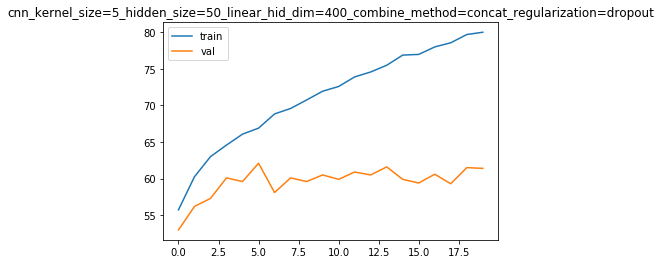

After training for 10 epochs
Train Acc 80.372
Val Acc 61.2
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 51.7, Train Acc: 51.902
Epoch: [1/10], Step: [600/782], Validation Acc: 53.7, Train Acc: 55.276
Epoch: [2/10], Step: [300/782], Validation Acc: 54.9, Train Acc: 57.552
Epoch: [2/10], Step: [600/782], Validation Acc: 56.0, Train Acc: 59.158
Epoch: [3/10], Step: [300/782], Validation Acc: 55.9, Train Acc: 59.408
Epoch: [3/10], Step: [600/782], Validation Acc: 58.4, Train Acc: 61.515
Epoch: [4/10], Step: [300/782], Validation Acc: 57.7, Train Acc: 63.102
Epoch: [4/10], Step: [600/782], Validation Acc: 56.8, Train Acc: 64.017
Epoch: [5/10], Step: [300/782], Validation Acc: 59.5, Train Acc: 65.562
Epoch: [5/10], Step: [600/782], Validation Acc: 58.5, Train Acc: 66.023
Epoch: [6/10], Step: [300/782], Validation Acc: 58.5, Train Acc: 66.649
Epoch: [6/10], Step: [600/782], Validation Acc: 59.0, T

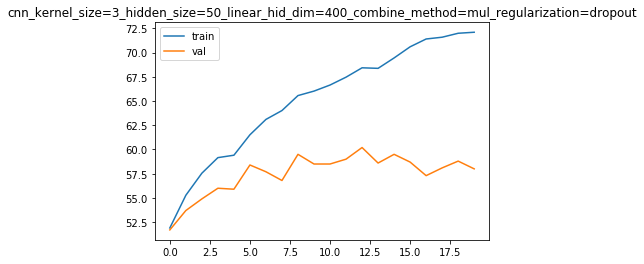

After training for 10 epochs
Train Acc 72.876
Val Acc 59.4
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 47.9, Train Acc: 48.072
Epoch: [1/10], Step: [600/782], Validation Acc: 56.6, Train Acc: 54.581
Epoch: [2/10], Step: [300/782], Validation Acc: 54.1, Train Acc: 57.577
Epoch: [2/10], Step: [600/782], Validation Acc: 56.4, Train Acc: 58.198
Epoch: [3/10], Step: [300/782], Validation Acc: 55.9, Train Acc: 60.918
Epoch: [3/10], Step: [600/782], Validation Acc: 55.8, Train Acc: 61.725
Epoch: [4/10], Step: [300/782], Validation Acc: 56.4, Train Acc: 63.852
Epoch: [4/10], Step: [600/782], Validation Acc: 57.7, Train Acc: 64.462
Epoch: [5/10], Step: [300/782], Validation Acc: 54.5, Train Acc: 64.809
Epoch: [5/10], Step: [600/782], Validation Acc: 55.9, Train Acc: 66.807
Epoch: [6/10], Step: [300/782], Validation Acc: 56.3, Train Acc: 67.965
Epoch: [6/10], Step: [600/782], Validation Acc: 56.2, T

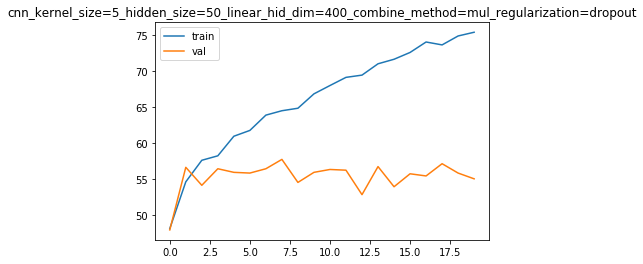

After training for 10 epochs
Train Acc 76.34
Val Acc 57.0
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=add
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 49.1, Train Acc: 50.369
Epoch: [1/10], Step: [600/782], Validation Acc: 51.3, Train Acc: 52.941
Epoch: [2/10], Step: [300/782], Validation Acc: 52.5, Train Acc: 55.727
Epoch: [2/10], Step: [600/782], Validation Acc: 53.3, Train Acc: 56.501
Epoch: [3/10], Step: [300/782], Validation Acc: 54.5, Train Acc: 58.834
Epoch: [3/10], Step: [600/782], Validation Acc: 54.4, Train Acc: 59.039
Epoch: [4/10], Step: [300/782], Validation Acc: 55.2, Train Acc: 61.23
Epoch: [4/10], Step: [600/782], Validation Acc: 55.1, Train Acc: 60.567
Epoch: [5/10], Step: [300/782], Validation Acc: 55.1, Train Acc: 62.61
Epoch: [5/10], Step: [600/782], Validation Acc: 55.7, Train Acc: 62.68
Epoch: [6/10], Step: [300/782], Validation Acc: 55.1, Train Acc: 62.64
Epoch: [6/10], Step: [600/782], Validation Acc: 54.3, Train 

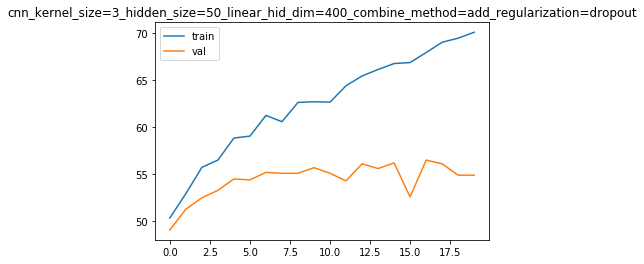

After training for 10 epochs
Train Acc 68.905
Val Acc 54.6
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=add
regularization=dropout
Epoch: [1/10], Step: [300/782], Validation Acc: 47.5, Train Acc: 47.16
Epoch: [1/10], Step: [600/782], Validation Acc: 51.9, Train Acc: 53.935
Epoch: [2/10], Step: [300/782], Validation Acc: 54.2, Train Acc: 56.606
Epoch: [2/10], Step: [600/782], Validation Acc: 55.8, Train Acc: 58.336
Epoch: [3/10], Step: [300/782], Validation Acc: 57.0, Train Acc: 60.359
Epoch: [3/10], Step: [600/782], Validation Acc: 57.2, Train Acc: 61.61
Epoch: [4/10], Step: [300/782], Validation Acc: 55.3, Train Acc: 62.502
Epoch: [4/10], Step: [600/782], Validation Acc: 57.3, Train Acc: 63.341
Epoch: [5/10], Step: [300/782], Validation Acc: 55.5, Train Acc: 64.87
Epoch: [5/10], Step: [600/782], Validation Acc: 55.9, Train Acc: 65.484
Epoch: [6/10], Step: [300/782], Validation Acc: 57.7, Train Acc: 66.735
Epoch: [6/10], Step: [600/782], Validation Acc: 55.4, Trai

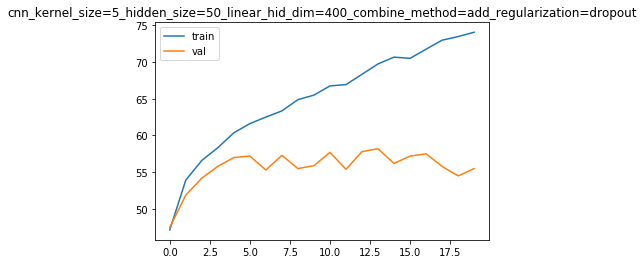

After training for 10 epochs
Train Acc 74.137
Val Acc 55.9
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=weight_decay
Epoch: [1/10], Step: [300/782], Validation Acc: 57.0, Train Acc: 58.011
Epoch: [1/10], Step: [600/782], Validation Acc: 58.3, Train Acc: 60.421
Epoch: [2/10], Step: [300/782], Validation Acc: 60.9, Train Acc: 63.689
Epoch: [2/10], Step: [600/782], Validation Acc: 61.9, Train Acc: 64.894
Epoch: [3/10], Step: [300/782], Validation Acc: 60.7, Train Acc: 66.168
Epoch: [3/10], Step: [600/782], Validation Acc: 61.7, Train Acc: 67.48
Epoch: [4/10], Step: [300/782], Validation Acc: 60.8, Train Acc: 68.178
Epoch: [4/10], Step: [600/782], Validation Acc: 63.2, Train Acc: 68.235
Epoch: [5/10], Step: [300/782], Validation Acc: 60.0, Train Acc: 67.627
Epoch: [5/10], Step: [600/782], Validation Acc: 60.6, Train Acc: 68.239
Epoch: [6/10], Step: [300/782], Validation Acc: 58.4, Train Acc: 65.394
Epoch: [6/10], Step: [600/782], Validation Acc: 

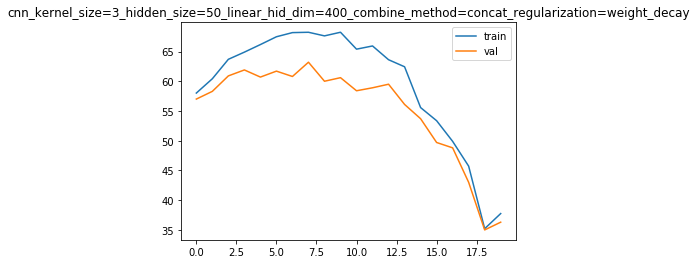

After training for 10 epochs
Train Acc 33.83
Val Acc 34.1
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=concat
regularization=weight_decay
Epoch: [1/10], Step: [300/782], Validation Acc: 56.3, Train Acc: 57.005
Epoch: [1/10], Step: [600/782], Validation Acc: 57.1, Train Acc: 60.49
Epoch: [2/10], Step: [300/782], Validation Acc: 59.2, Train Acc: 63.744
Epoch: [2/10], Step: [600/782], Validation Acc: 59.2, Train Acc: 64.623
Epoch: [3/10], Step: [300/782], Validation Acc: 59.7, Train Acc: 66.931
Epoch: [3/10], Step: [600/782], Validation Acc: 61.0, Train Acc: 67.344
Epoch: [4/10], Step: [300/782], Validation Acc: 61.2, Train Acc: 68.84
Epoch: [4/10], Step: [600/782], Validation Acc: 61.4, Train Acc: 69.525
Epoch: [5/10], Step: [300/782], Validation Acc: 60.8, Train Acc: 69.428
Epoch: [5/10], Step: [600/782], Validation Acc: 59.2, Train Acc: 69.121
Epoch: [6/10], Step: [300/782], Validation Acc: 60.1, Train Acc: 69.134
Epoch: [6/10], Step: [600/782], Validation Acc: 60

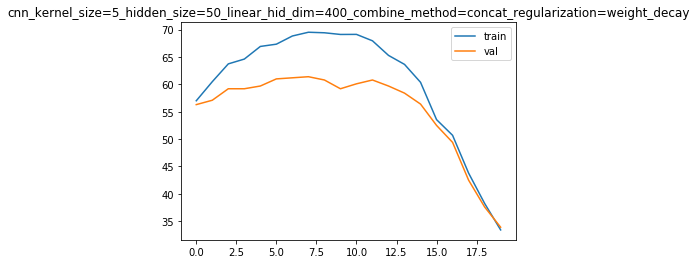

After training for 10 epochs
Train Acc 33.486
Val Acc 34.2
cnn
kernel_size=3
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=weight_decay
Epoch: [1/10], Step: [300/782], Validation Acc: 53.5, Train Acc: 51.703
Epoch: [1/10], Step: [600/782], Validation Acc: 51.2, Train Acc: 53.585
Epoch: [2/10], Step: [300/782], Validation Acc: 56.0, Train Acc: 57.822
Epoch: [2/10], Step: [600/782], Validation Acc: 58.6, Train Acc: 60.696
Epoch: [3/10], Step: [300/782], Validation Acc: 57.4, Train Acc: 61.384
Epoch: [3/10], Step: [600/782], Validation Acc: 58.0, Train Acc: 62.712
Epoch: [4/10], Step: [300/782], Validation Acc: 59.2, Train Acc: 63.289
Epoch: [4/10], Step: [600/782], Validation Acc: 59.2, Train Acc: 63.712
Epoch: [5/10], Step: [300/782], Validation Acc: 59.1, Train Acc: 62.712
Epoch: [5/10], Step: [600/782], Validation Acc: 57.3, Train Acc: 62.071
Epoch: [6/10], Step: [300/782], Validation Acc: 56.1, Train Acc: 60.413
Epoch: [6/10], Step: [600/782], Validation Acc: 56

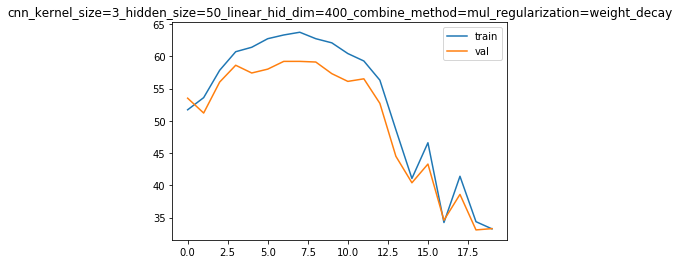

After training for 10 epochs
Train Acc 34.244
Val Acc 33.3
cnn
kernel_size=5
hidden_size=50
linear_hid_dim=400
combine_method=mul
regularization=weight_decay
Epoch: [1/10], Step: [300/782], Validation Acc: 51.7, Train Acc: 51.098
Epoch: [1/10], Step: [600/782], Validation Acc: 54.1, Train Acc: 55.11
Epoch: [2/10], Step: [300/782], Validation Acc: 57.0, Train Acc: 59.298
Epoch: [2/10], Step: [600/782], Validation Acc: 56.6, Train Acc: 60.15
Epoch: [3/10], Step: [300/782], Validation Acc: 56.7, Train Acc: 60.649
Epoch: [3/10], Step: [600/782], Validation Acc: 57.7, Train Acc: 63.204
Epoch: [4/10], Step: [300/782], Validation Acc: 57.9, Train Acc: 64.121
Epoch: [4/10], Step: [600/782], Validation Acc: 56.6, Train Acc: 64.926
Epoch: [5/10], Step: [300/782], Validation Acc: 57.3, Train Acc: 64.717
Epoch: [5/10], Step: [600/782], Validation Acc: 55.1, Train Acc: 62.575
Epoch: [6/10], Step: [300/782], Validation Acc: 54.4, Train Acc: 61.776
Epoch: [6/10], Step: [600/782], Validation Acc: 55.2

In [ ]:
with open(os.path.join(model_type_list[0], 'accuracy.txt'), 'w') as thefile:
    for model_type in model_type_list:
        for hidden_size in hidden_size_list:
            for linear_hid_dim in linear_hid_dim_list:
                for regularization in regularization_list:
                    for combine_method in combine_method_list:
                    
                                if(model_type == 'cnn'):
                                    for kernel_size in kernel_size_list:
                                        train_acc, val_acc, model = train_and_evaluate(model_type, kernel_size , hidden_size, linear_hid_dim, 
                                                                           combine_method, regularization);
                                        
                                        thefile.write(','.join([model_type, str(kernel_size), str(hidden_size), str(linear_hid_dim), 
                                                           str(combine_method), str(regularization), str(train_acc),
                                                               str(val_acc)])+'\n')
                                else:
                                        kernel_size = None;
                                        
                                        train_acc, val_acc, model = train_and_evaluate(model_type, kernel_size , hidden_size, linear_hid_dim, 
                                                                           combine_method, regularization);
                                        
                                        thefile.write(','.join([model_type,  str(hidden_size), str(linear_hid_dim), 
                                                           str(combine_method), str(regularization), str(train_acc),
                                                               str(val_acc)])+'\n')
                                        
                                if val_acc > best_acc:
                                    best_acc = val_acc;
                                    best_hidden_size, best_linear_hid_dim = hidden_size, linear_hid_dim
                                    best_kernel_size, best_combine_method = kernel_size, combine_method
                                    torch.save(model, os.path.join('.', model_type_list[0], 'best_'+model_type+'.pth') )
                                    

In [ ]:
print(model_type_list)
print('\n'.join(['best_val_acc: '+ str(best_acc), 
                    'best_hidden_size: '+str(best_hidden_size), 'best_linear_hid_dim: '+str(best_linear_hid_dim),
                    'best_kernel_size: '+str(best_kernel_size), 'best_combine_method: '+combine_method]))